In [1]:
!pip install -U mxnet-cu101==1.7.0
!pip install d2l==0.16.4


     |███████████████████████████████▌| 834.1MB 1.3MB/s eta 0:00:10tcmalloc: large alloc 1147494400 bytes == 0x559af41b8000 @  0x7fd996325615 0x559abb46dcdc 0x559abb54d52a 0x559abb470afd 0x559abb561fed 0x559abb4e4988 0x559abb4df4ae 0x559abb4723ea 0x559abb4e47f0 0x559abb4df4ae 0x559abb4723ea 0x559abb4e132a 0x559abb562e36 0x559abb4e0853 0x559abb562e36 0x559abb4e0853 0x559abb562e36 0x559abb4e0853 0x559abb562e36 0x559abb4e0853 0x559abb47230a 0x559abb4e060e 0x559abb4df7ad 0x559abb4723ea 0x559abb4e03b5 0x559abb47230a 0x559abb4e03b5 0x559abb4df4ae 0x559abb4723ea 0x559abb4e132a 0x559abb4df4ae
     |████████████████████████████████| 846.0MB 21kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 81kB 5.8MB/s 


In [2]:
import os
import json
import numpy as np
import pandas as pd
COL_NAME_USER_ID = "userId"
COL_NAME_MOVIE_ID = "movieId"
COL_NAME_ITEM_ID = COL_NAME_MOVIE_ID
COL_NAME_RATING = "rating"
COL_NAME_MOVIE_RATINGS = "movies_and_ratings"

from google.colab import drive
drive.mount("/content/drive",force_remount=True)

class Utility:

    def __init__(self, _base_path:str='/content/drive/MyDrive/CSE547_Final_Project/ml-100k/ratings_split/iter_1/', _user_id_col="userId", _movie_id_col="movieId", _rating_col="rating"):
        """Init the utility class

        Keyword arguments
        base_path -- The directory where files are located. 
        """

        if not os.path.isdir(_base_path):
            raise OSError(f'{_base_path} is not a directory')
        
        self.base_path = _base_path

        self.training_file = 'ratings_train.csv'
        self.test_file = 'ratings_test.csv'
        self.validation_file = 'ratings_validation.csv'

        self.user_to_idx_file = "user_to_idx.json"
        self.movie_to_idx_file = "movie_to_idx.json"

        self.k_anonymized_postfix = '_anonymized.csv'
        self.k_anonymized_map_postfix = '_anonymized_idx_to_kanon_idx.json'

        self.user_id_col=_user_id_col
        self.movie_id_col=_movie_id_col
        self.rating_col=_rating_col
    
    def euclidean_distance(self, point1, point2):
        return np.linalg.norm(point1 - point2) ** 2
    
    def manhattan_distance(self, point1, point2):
        return abs(point1 - point2).sum()
    
    def find_closest_point(self, points_list, point, metric='euclidean'):

        min_distance = float('inf')
        min_distance_idx = -1
        i = 0
        for p in points_list:
            if metric == 'euclidean':
                distance = self.euclidean_distance(p, point)
            elif metric == 'manhattan':
                self.manhattan_distance(p, point)
            else:
                print('Function not implemented!')

            if distance < min_distance:
                min_distance = distance
                min_distance_idx = i
            
            i += 1
        
        return min_distance_idx
    
    def flatten_matrix_into_dataframe(self, matrix):
      value_vars = [v for v in matrix.columns.values if v != COL_NAME_USER_ID]
      DEFAULT_VARIABLE_NAME_IN_MELT="variable"
      DEFAULT_VALUE_NAME_IN_MELT="value"
      movies_dict = self.get_movie_index()
      matrix = matrix \
        .melt(id_vars=[COL_NAME_USER_ID], value_vars=value_vars) \
        .rename(columns={DEFAULT_VARIABLE_NAME_IN_MELT: COL_NAME_MOVIE_ID, DEFAULT_VALUE_NAME_IN_MELT: COL_NAME_RATING}) \
        .apply(lambda x : pd.to_numeric(x, downcast='integer'))
      matrix[COL_NAME_MOVIE_ID] = matrix[COL_NAME_MOVIE_ID].apply(lambda x: movies_dict[x])
      matrix[COL_NAME_USER_ID] = matrix[COL_NAME_USER_ID] + 1
      matrix = matrix[matrix[COL_NAME_RATING] > 0]
      return matrix

    def get_training_data_file_path(self, k:int):
      return os.path.join(self.base_path, f"{k}{self.k_anonymized_postfix}")

    def get_test_data_file_path(self):
      return os.path.join(self.base_path, self.test_file)

    def get_training_data(self, k:int):
      mldf = pd.read_csv(self.get_training_data_file_path(k), header=None).reset_index().rename(columns={'index': COL_NAME_USER_ID})
      mldf= self.flatten_matrix_into_dataframe(mldf)
      return mldf, len(mldf[COL_NAME_USER_ID].unique()), len(mldf[COL_NAME_MOVIE_ID].unique())

    def get_training_data_for_evaluation(self):
      mldf = pd.read_csv(self.get_training_data_path())
      return self._group_and_get_sets_for_evaluation(mldf)

    def get_test_data(self):
      return pd.read_csv(self.get_test_data_file_path()).apply(lambda x : pd.to_numeric(x, downcast='integer'))

    def _group_and_get_sets_for_evaluation(self, df):
      testdf=df.sort_values(by=COL_NAME_RATING, ascending=False)
      grouped=testdf.groupby(COL_NAME_USER_ID).agg({COL_NAME_MOVIE_ID:lambda x: list(x), COL_NAME_RATING:lambda x: list(x)})
      grouped[COL_NAME_MOVIE_RATINGS] = grouped.apply(lambda x: list(zip(x[COL_NAME_MOVIE_ID], x[COL_NAME_RATING])), axis=1)
      grouped=grouped.drop(columns=[COL_NAME_RATING])
      return grouped

    def get_unanonymized_training_data(self):
      df = pd.read_csv(self.get_training_data_path())
      return df.apply(pd.to_numeric), len(df[COL_NAME_USER_ID].unique()), len(df[COL_NAME_MOVIE_ID].unique())

    def get_test_data_for_evaluation(self):
      testdf=Utility().get_test_data()
      return self._group_and_get_sets_for_evaluation(testdf)
  
    def get_training_data_path(self, base_path=""):
        """Get path to training file

        Keyword arguments
        base_path -- The directory where files are located. 
        """
        if not base_path:
            base_path = self.base_path
        
        if not os.path.isdir(base_path):
            raise OSError(f'{base_path} is not a directory')
        
        file_path = os.path.join(base_path, self.training_file)
        if not os.path.exists(file_path):
            raise OSError(f'{file_path} is not a directory')
        
        return file_path

    def get_test_data_path(self, base_path=""):
        """Get path to test file

        Keyword arguments
        base_path -- The directory where files are located. 
        """
        if not base_path:
            base_path = self.base_path
        
        if not os.path.isdir(base_path):
            raise OSError(f'{base_path} is not a directory')
        
        file_path = os.path.join(base_path, self.test_file)
        if not os.path.exists(file_path):
            raise OSError(f'{file_path} is not a directory')

        return file_path
    
    def get_validation_data_path(self, base_path=""):
        """Get path to validation file

        Keyword arguments
        base_path -- The directory where files are located. 
        """
        if not base_path:
            base_path = self.base_path
        
        if not os.path.isdir(base_path):
            raise OSError(f'{base_path} is not a directory')
        
        file_path = os.path.join(base_path, self.validation_file)
        if not os.path.exists(file_path):
            raise OSError(f'{file_path} is not a directory')

        return file_path
    
    def get_train_data_user_map_path(self, base_path=""):
        """Get path to user id to train index file map

        Keyword arguments
        base_path -- The directory where files are located. 
        """
        if not base_path:
            base_path = self.base_path
        
        if not os.path.isdir(base_path):
            raise OSError(f'{base_path} is not a directory')
        
        file_path = os.path.join(base_path, self.user_to_idx_file)
        if not os.path.exists(file_path):
            raise OSError(f'{file_path} is not a directory')

        return file_path
    
    def get_train_data_movie_map_path(self, base_path=""):
        """Get path to movie id to train index file map

        Keyword arguments
        base_path -- The directory where files are located. 
        """
        if not base_path:
            base_path = self.base_path
        
        if not os.path.isdir(base_path):
            raise OSError(f'{base_path} is not a directory')
        
        file_path = os.path.join(base_path, self.movie_to_idx_file)
        if not os.path.exists(file_path):
            raise OSError(f'{file_path} is not a directory')

        return file_path

    def get_k_anonymized_data_path(self, k, base_path=""):
        """Get path to k-anonymzied file

        Keyword arguments
        k -- 
        base_path -- The directory where files are located. 
        """
        if not base_path:
            base_path = self.base_path
        
        if not os.path.isdir(base_path):
            raise OSError(f'{base_path} is not a directory')
        
        k_file_name = str(k) + self.k_anonymized_postfix

        file_path = os.path.join(base_path, k_file_name)
        if not os.path.exists(file_path):
            raise OSError(f'{file_path} is not a directory')

        return file_path
    
    def _coalesce_path(self,path1, path2):
      return path1 if path1 != "" else path2

    def get_utility_matrix_from_train(self, base_path=""):
        base_path = self._coalesce_path(base_path, self.base_path)
        complete_file_path = os.path.join(base_path, self.training_file)
        if not os.path.exists(complete_file_path):
            raise OSError(f'{complete_file_path} is not a file')
        
        df = pd.read_csv(complete_file_path)
        
        movie_to_idx_path = self.get_train_data_movie_map_path(base_path)
        with open(movie_to_idx_path) as json_file:
            movie_id_to_idx_dict = json.load(json_file)

        users = df.userId.unique()
        test_user_dict = {users[i]: i for i in range(len(users))}

        num_users = len(df.userId.unique())
        num_movies = len(movie_id_to_idx_dict) + 1
        utility_matrix = np.zeros((num_users, num_movies))

        for index, row in df.iterrows():
            movie_id, rating = str(int(row[self.movie_id_col])), float(row[self.rating_col])
            utility_matrix[test_user_dict[row[self.user_id_col]]][0] = int(row[self.user_id_col])
            
            if movie_id in movie_id_to_idx_dict.keys():
                utility_matrix[test_user_dict[row[self.user_id_col]]][movie_id_to_idx_dict[movie_id]] = rating
            else:
                print(f'Movie ID {movie_id} not found!')
        
        return utility_matrix
    
    def get_k_anonymized_map_path(self, k, base_path=""):
        """Get path to k-anonymzied map. 
        {k}_anonymized_idx_to_kanon_idx.json --> the mapping from user index 
        (row in the ratings_train.csv) to the row index in the 
        corresponding {k}_anonymized.csv file

        Keyword arguments
        k -- 
        base_path -- The directory where files are located. 
        """
        if not base_path:
            base_path = self.base_path
        
        if not os.path.isdir(base_path):
            raise OSError(f'{base_path} is not a directory')
        
        k_file_name = str(k) + self.k_anonymized_map_postfix
        
        file_path = os.path.join(base_path, k_file_name)
        if not os.path.exists(file_path):
            raise OSError(f'{file_path} is not a directory')

        return file_path
    
    def get_movie_index(self):
      movie_to_idx_path = self.get_train_data_movie_map_path(self.base_path)
      with open(movie_to_idx_path) as json_file:
          movie_id_to_idx_dict = json.load(json_file)
      return {v:int(k) for k,v in movie_id_to_idx_dict.items()}

    def get_movie_to_col_index(self):
      movie_to_idx_path = self.get_train_data_movie_map_path(self.base_path)
      with open(movie_to_idx_path) as json_file:
          movie_id_to_idx_dict = json.load(json_file)
      return {int(k):v for k,v in movie_id_to_idx_dict.items()}

    def get_feature_vector_for_user(self, movie_ratings:list, base_path=""):
        """Returns a vector, with the same dimentions as the 
        training dataset. 

        Keyword arguments
        movie_ratings -- A list of tuples. Each tuple should be
        as follows: (movie_id, rating)
        """
        movie_to_idx_path = self.get_train_data_movie_map_path(base_path)
        with open(movie_to_idx_path) as json_file:
            movie_id_to_idx_dict = json.load(json_file)
        
        feature_vec = [0 for _ in range(len(movie_id_to_idx_dict))]
        for movie_id, rating in movie_ratings:
            movie_id, rating = str(movie_id), int(rating)

            if movie_id in movie_id_to_idx_dict.keys():
                feature_vec[movie_id_to_idx_dict[movie_id]] = rating
            else:
                print(f'Movie ID {movie_id} not found!')
        
        return feature_vec
    
    def get_closest_k_cluster_to_user_id(self, k:int, metric="euclidean", base_path=""):
        id_to_idx_path = self.get_train_data_user_map_path(base_path)
        idx_to_kidx_path = self.get_k_anonymized_map_path(k, base_path)
        k_anon_data_path = self.get_k_anonymized_data_path(k, base_path)

        with open(id_to_idx_path) as json_file:
            id_to_idx_dict = json.load(json_file)
        
        with open(idx_to_kidx_path) as json_file:
            idx_to_kidx_path_dict = json.load(json_file)

        k_anaon_data = pd.read_csv(k_anon_data_path, sep=',', header=None).values
        
        u_matrix = self.get_utility_matrix_from_train(base_path)
        user_to_cluster_dict = {}
        for um in u_matrix:
            user_id = str(int(um[0]))
            row_vec = um[1:]
        
            # Easy case - We have trained on this user before
            # Just need to lookup, to see what cluster they belong to
            if user_id in id_to_idx_dict.keys() and\
            str(id_to_idx_dict[user_id]) in idx_to_kidx_path_dict.keys():            
                user_to_cluster_dict[int(user_id)] = idx_to_kidx_path_dict[str(id_to_idx_dict[user_id])]
            else:
                # print(f'{user_id} not found in training data!')
                user_to_cluster_dict[int(user_id)] = self.find_closest_point(k_anaon_data, row_vec)
                print(f'{user_id} mapped to {user_to_cluster_dict[int(user_id)]}')
        
        return user_to_cluster_dict

Mounted at /content/drive


In [3]:
test_movies=set(Utility().get_test_data()["movieId"].unique().tolist())

In [4]:
train_movies=set(Utility().get_training_data(3)[0][COL_NAME_MOVIE_ID].unique().tolist())

In [5]:
print(f"train movies: {len(train_movies)},\t test movies: {len(test_movies)}")
print(f"# movies in train but not in test: {len(train_movies - test_movies)}")
print(f"# movies in test but not in train: {len(test_movies - train_movies)}")

train movies: 9007,	 test movies: 3649
# movies in train but not in test: 5726
# movies in test but not in train: 368


In [3]:
import random
import mxnet as mx
from mxnet import autograd, gluon, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

In [4]:
class NeuMF(nn.Block):
    def __init__(self, num_factors, num_users, num_items, nums_hiddens,
                 **kwargs):
        super(NeuMF, self).__init__(**kwargs)
        self.P = nn.Embedding(num_users, num_factors)
        self.Q = nn.Embedding(num_items, num_factors)
        self.U = nn.Embedding(num_users, num_factors)
        self.V = nn.Embedding(num_items, num_factors)
        self.mlp = nn.Sequential()
        for num_hiddens in nums_hiddens:
            self.mlp.add(
                nn.Dense(num_hiddens, activation='relu', use_bias=True))
        self.prediction_layer = nn.Dense(1, activation='sigmoid',
                                         use_bias=False)

    def forward(self, user_id, item_id):
        p_mf = self.P(user_id)
        q_mf = self.Q(item_id)
        gmf = p_mf * q_mf
        p_mlp = self.U(user_id)
        q_mlp = self.V(item_id)
        mlp = self.mlp(np.concatenate([p_mlp, q_mlp], axis=1))
        con_res = np.concatenate([gmf, mlp], axis=1)
        return self.prediction_layer(con_res)

In [5]:
class PRDataset(gluon.data.Dataset):
    def __init__(self, users, items, candidates, all_items):
        self.users = users
        self.items = items
        self.cand = candidates
        self.all = set(all_items)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        neg_items = list(self.all - set(self.cand[int(self.users[idx])]))
        indices = random.randint(0, len(neg_items) - 1)
        return self.users[idx], self.items[idx], neg_items[indices]

In [9]:
def hit_and_auc(rankedlist, test_matrix, k):
    # hit rate @ k
    hits_k = [(idx, val) for idx, val in enumerate(rankedlist[:k])
              if val in set(test_matrix)]
    hits_all = [(idx, val) for idx, val in enumerate(rankedlist)
                if val in set(test_matrix)]
    hits_k = [(idx, val) for idx, val in enumerate(rankedlist[:k])
              if val in set(test_matrix)]
    max = len(rankedlist) - 1
    auc = 1.0 * (max - hits_all[0][0]) / max if len(hits_all) > 0 else 0
    return len(hits_k), auc

In [10]:
t=[(1,2.5),(6,2.7)]
w=[(1,3),(10,9.0),(12,3.5)]


In [6]:
def get_metrics(predicted_values, test_values):
  relevant_test_data = set(test_values)
  test_data_set = set(test_values)
  num_relevant_predictions = len([1 for x in predicted_values if x in relevant_test_data])
  num_predictions = len(predicted_values)
  num_relevant_items = len(relevant_test_data)
  precision = num_relevant_predictions / num_predictions
  recall = num_relevant_predictions / num_relevant_items
  hit_count = len([1 for x in predicted_values if x in test_data_set]) 
  return num_relevant_predictions, num_predictions, num_relevant_items, hit_count, len(test_data_set)

from tqdm.notebook import tqdm
def get_evaluation_metrics(result_list, top_k=50, debug=False):
  test_data = Utility().get_test_data_for_evaluation()
  num_relevant_predictions = 0
  num_predictions = 0
  num_relevant_items = 0
  hit_count = 0
  total_relevant_items = 0
  test_users = test_data.index.values
  computed_over_n_users = 0
  for user_id in tqdm(test_users):
    top_items = test_data.loc[user_id, COL_NAME_MOVIE_RATINGS][0:top_k]
    top_items = [t[0] for t in top_items]
    if user_id not in result_list:
      continue
    prediction_list = result_list[user_id]
    predicted_values = [p[0] for p in prediction_list[0:top_k]]
    if debug:
      print(predicted_values)
      print(top_items)
      print()
    _num_relevant_predictions, _num_predictions, _num_relevant_items, _hit_count, _total_relevant_items = get_metrics(predicted_values=predicted_values, test_values=top_items)
    num_relevant_predictions += _num_relevant_predictions
    num_predictions += _num_predictions
    num_relevant_items += _num_relevant_items
    hit_count += _hit_count
    total_relevant_items += _total_relevant_items
    computed_over_n_users += 1
  if debug:
    print(f"Computed values over {computed_over_n_users} users.")
  precision_at_k = num_relevant_predictions / num_predictions
  recall_at_k = num_relevant_predictions / total_relevant_items
  hit_rate_at_k = recall_at_k # these are the same ?
  return precision_at_k, recall_at_k 


def evaluate_ranking_v2(net, devices,k):
  with autograd.predict_mode():
    test_data = Utility().get_test_data_for_evaluation()
    train_data = Utility().get_training_data_for_evaluation() 
    movie_index = Utility().get_movie_index()
    movie_to_col_index = Utility().get_movie_to_col_index()
    user_to_cluster = Utility().get_closest_k_cluster_to_user_id(k if k!=0 else 3)
    ranked_list, ranked_items, hit_rate, auc = {}, {}, [], []
    all_items = set(movie_to_col_index.keys())
    for u in tqdm(user_to_cluster.keys()):
        # remove all the positive items to get just the negative items.

        neg_items = list(all_items - set(train_data.loc[int(u)][COL_NAME_MOVIE_ID]))
        cluster_ids, item_ids, x, scores = [], [], [], []
        [item_ids.append(movie_to_col_index[i] if k!=0 else i) for i in neg_items]
        [cluster_ids.append(user_to_cluster[int(u)] if k!=0 else int(u)) for _ in neg_items]
        x.extend([np.array(cluster_ids)])
        x.extend([np.array(item_ids)])
        test_data_iter = gluon.data.DataLoader(gluon.data.ArrayDataset(*x),
                                               shuffle=False,
                                               last_batch="keep",
                                               batch_size=1024)
        for index, values in enumerate(test_data_iter):
            x = [
                gluon.utils.split_and_load(v, devices, even_split=False)
                for v in values]
            scores.extend([list(net(*t).asnumpy()) for t in zip(*x)])
        scores = [item for sublist in scores for item in sublist]
        item_ids = [movie_index[m] for m in item_ids] if k!=0 else item_ids
        item_scores = list(zip(item_ids, [s[0] for s in scores]))
        item_scores = sorted(item_scores, key=lambda t: t[1], reverse=True)
        ranked_list[u] = item_scores
        #num_relevant_predictions, num_predictions, num_relevant_items, hit_count, test_length = get_metrics(ranked_items[u], test_data.loc[int(u),COL_NAME_MOVIE_RATINGS].values[0], N)
    return ranked_list

def evaluate_ranking(net, test_input, seq, candidates, num_users, num_items,
                     devices):
    ranked_list, ranked_items, hit_rate, auc = {}, {}, [], []
    all_items = set([i for i in range(num_items)])
    for u in range(num_users):
        neg_items = list(all_items - set(candidates[int(u)]))
        user_ids, item_ids, x, scores = [], [], [], []
        [item_ids.append(i) for i in neg_items]
        [user_ids.append(u) for _ in neg_items]
        x.extend([np.array(user_ids)])
        if seq is not None:
            x.append(seq[user_ids, :])
        x.extend([np.array(item_ids)])
        test_data_iter = gluon.data.DataLoader(gluon.data.ArrayDataset(*x),
                                               shuffle=False,
                                               last_batch="keep",
                                               batch_size=1024)
        for index, values in enumerate(test_data_iter):
            x = [
                gluon.utils.split_and_load(v, devices, even_split=False)
                for v in values]
            scores.extend([list(net(*t).asnumpy()) for t in zip(*x)])
        scores = [item for sublist in scores for item in sublist]
        item_scores = list(zip(item_ids, scores))
        print(item_scores)
        ranked_list[u] = sorted(item_scores, key=lambda t: t[1], reverse=True)
        ranked_items[u] = [r[0] for r in ranked_list[u]]
        temp = hit_and_auc(ranked_items[u], test_input[u], 50)
        num_relevant_predictions, num_predictions, num_relevant_items, hit_count, test_length = get_metrics(ranked_items[u], test_input[u])
        hit_rate.append(temp[0])
        auc.append(temp[1])
    return np.mean(np.array(hit_rate)), np.mean(np.array(auc))

In [7]:
def train_ranking(net, train_iter, test_iter, loss, trainer, test_seq_iter,
                  num_users, num_items, num_epochs, devices, evaluator,
                  candidates, eval_step=1):
    timer, hit_rate, auc = d2l.Timer(), 0, 0
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['test hit rate', 'test AUC'])
    for epoch in range(num_epochs):
        metric, l = d2l.Accumulator(3), 0.
        for i, values in enumerate(train_iter):
            input_data = []
            for v in values:
                input_data.append(gluon.utils.split_and_load(v, devices))
            with autograd.record():
                p_pos = [net(*t) for t in zip(*input_data[0:-1])]
                p_neg = [
                    net(*t) for t in zip(*input_data[0:-2], input_data[-1])]
                ls = [loss(p, n) for p, n in zip(p_pos, p_neg)]
            [l.backward(retain_graph=False) for l in ls]
            l += sum([l.asnumpy() for l in ls]).mean() / len(devices)
            trainer.step(values[0].shape[0])
            metric.add(l, values[0].shape[0], values[0].size)
            timer.stop()
        with autograd.predict_mode():
            if (epoch + 1) % eval_step == 0:
                if evaluator is None:
                  hit_rate,auc=0.50,0.50
                else:
                  hit_rate, auc = evaluator(net, test_iter, test_seq_iter,
                                            candidates, num_users, num_items,
                                            devices)
                animator.add(epoch + 1, (hit_rate, auc))
    print(f'train loss {metric[0] / metric[1]:.3f}, '
          f'test hit rate {float(hit_rate):.3f}, test AUC {float(auc):.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

In [110]:



mldf, num_users, num_items = Utility().get_unanonymized_training_data()


In [113]:
Utility().get_unanonymized_training_data()

,userId,movieId,rating
0,187,47997,0.5
1,19,2011,2.0
2,463,8622,3.5
3,274,4167,3.5
4,590,858,5.0
...,...,...,...
80764,179,592,3.0
80765,448,180,3.5
80766,89,2294,3.5
80767,403,3006,4.5


In [118]:

def add_missing_users( d, num_users):
  for i in range(num_users):
    if i not in d:
      d[i] = []
  return d


  
batch_size = 1024
#df, num_users, num_items = d2l.read_data_ml100k()
df,num_users,num_items = Utility().get_unanonymized_training_data()
train_data = df
#train_data, test_data = d2l.split_data_ml100k(df, num_users, num_items,
#                                              'random')
users_train, items_train, ratings_train, candidates = d2l.load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit")
#users_test, items_test, ratings_test, test_iter = d2l.load_data_ml100k(
#    test_data, num_users, num_items, feedback="implicit")

movie_index = Utility().get_movie_index()
#test_iter = add_missing_users(test_iter, num_users)
train_iter = gluon.data.DataLoader(
    PRDataset(users_train, items_train, candidates, list(movie_index.keys())), batch_size,
    True, last_batch="rollover", num_workers=d2l.get_dataloader_workers())

In [45]:
devices

[gpu(0)]

In [49]:
for i, values in enumerate(train_iter):
  input_data = []
  for v in values:
      print(v)
      input_data.append(gluon.utils.split_and_load(v, devices))
  #with autograd.predict_mode():
  #  [print(net(*t).asnumpy()) for t in zip(*input_data[0:-1])]
  print(*input_data[0])
  print("----")
  print(input_data)
  break


[118  24  11 ... 202 149  61] @cpu_shared(0)
[  422  5501 48637 ...  6057  1192  2406] @cpu_shared(0)
[8166 8718 2968 ... 2553 5158 7272] @cpu_shared(0)
[118  24  11 ... 202 149  61] @gpu(0)
----
[[array([118,  24,  11, ..., 202, 149,  61], dtype=int64, ctx=gpu(0))], [array([  422,  5501, 48637, ...,  6057,  1192,  2406], dtype=int64, ctx=gpu(0))], [array([8166, 8718, 2968, ..., 2553, 5158, 7272], dtype=int64, ctx=gpu(0))]]


We then create and initialize the model. we use a three-layer MLP with constant hidden size 10.


In [119]:
devices = d2l.try_all_gpus()
net = NeuMF(10, num_users, num_items, nums_hiddens=[10, 10, 10])
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))

In [16]:
devices

[gpu(0)]

The following code trains the model.


train loss 17.602, test hit rate 0.500, test AUC 0.500
9.2 examples/sec on [gpu(0)]


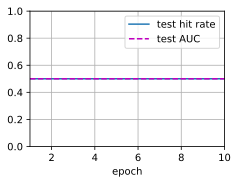

In [120]:
lr, num_epochs, wd, optimizer = 0.01, 10, 1e-5, 'adam'
loss = d2l.BPRLoss()
trainer = gluon.Trainer(net.collect_params(), optimizer, {
    "learning_rate": lr,
    'wd': wd})
#train_ranking(net, train_iter, test_iter, loss, trainer, None, num_users,
#              num_items, num_epochs, devices, evaluate_ranking, candidates)
train_ranking(net, train_iter, None, loss, trainer, None, num_users,
              num_items, num_epochs, devices, None, candidates)

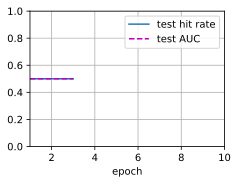

In [ ]:
import pickle
ks = [3,5,8,12,15,20,25]
google_drive_path = "drive/MyDrive/cse547/project"
devices = d2l.try_all_gpus()
batch_size = 1024
movie_index = Utility().get_movie_index()

evaluation_metrics = {
    k:{}
    for k in ks
}
for k in ks:
  print(f"Starting to process data for {k}...")
  mldf, num_users, num_items = Utility().get_training_data(k)
  df,num_users,num_items = mldf, num_users, num_items 
  train_data = df
  users_train, items_train, ratings_train, candidates = d2l.load_data_ml100k(
      train_data, num_users, num_items, feedback="implicit")
  train_iter = gluon.data.DataLoader(
      PRDataset(users_train, items_train, candidates, list(movie_index.keys())), batch_size,
      True, last_batch="rollover", num_workers=d2l.get_dataloader_workers())
  net = NeuMF(10, num_users, num_items, nums_hiddens=[10, 10, 10])
  net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
  lr, num_epochs, wd, optimizer = 0.01, 10, 1e-5, 'adam'
  loss = d2l.BPRLoss()
  trainer = gluon.Trainer(net.collect_params(), optimizer, {
      "learning_rate": lr,
      'wd': wd})
  train_ranking(net, train_iter, None, loss, trainer, None, num_users,
              num_items, num_epochs, devices, None, candidates)
  params_file_name = os.path.join(google_drive_path, f"params/{k}_anonymized_neumf.params")
  print(f"Saving params to: '{params_file_name}'")
  net.save_parameters(params_file_name)
  print(f"Done saving params to {params_file_name}.")
  ranked_list=evaluate_ranking_v2(net, devices, k)
  preds_file_name = os.path.join(google_drive_path, f"results/{k}_anonymized_neumf_predictions.pkl")
  print(f"Saving predictions to: '{preds_file_name}'")
  with open(preds_file_name, 'wb') as f:
    # Pickle dictionary using protocol 0.
    pickle.dump(ranked_list, preds_file_name)
  print(f"Done saving results to {preds_file_name}.")
  precision, recall = get_evaluation_metrics(ranked_list, 10, False)
  evaluation_metrics[k]["precision"] =  precision
  evaluation_metrics[k]["recall"] = recall
  print(f"Done processing {k} anon'd data.")


In [155]:
Utility().get_training_data(k)[0]

,userId,movieId,rating
0,1,1,1.000000
2,3,1,2.666667
3,4,1,3.333333
4,5,1,2.333333
5,6,1,3.000000
...,...,...,...
1828245,28,65514,1.333333
1828251,34,65514,1.333333
1828316,99,65514,1.166667
1828335,118,65514,1.166667


In [124]:
  ranked_list=evaluate_ranking_v2(net, devices, 0)


287 mapped to 165
306 mapped to 141
213 mapped to 202
108 mapped to 202


In [128]:
get_evaluation_metrics(ranked_list, 10, True)

[3577, 4962, 46, 259, 647, 1192, 1609, 1681, 2011, 2354]
[2654, 1073, 2987, 2993, 1220, 2115, 3273, 1954, 1298, 1282]

[32770, 131104, 131098, 32799, 46, 65577, 65585, 65588, 131130, 65601]
[3578, 115713, 71535]

[32770, 131104, 131098, 32799, 46, 65577, 65585, 65588, 131130, 65601]
[70946, 5764]

[46, 259, 647, 903, 1192, 1609, 1681, 2005, 2011, 2114]
[265, 1103, 1203, 125, 593, 1282, 4239, 232, 1641, 3408]

[32770, 131104, 131098, 32799, 46, 47, 65577, 65585, 65588, 131130]
[457]

[1609, 1681, 2011, 3577, 4225, 4962, 259, 647, 1192, 2354]
[36, 86, 368, 1049, 316, 553, 588, 783, 225, 569]

[32770, 131104, 131098, 32799, 46, 65577, 65585, 65588, 131130, 65601]
[480, 1, 49272, 5991, 4306, 5218, 7155, 4246, 4700, 8965]

[1, 32770, 131104, 131098, 32799, 46, 65577, 65585, 65588, 131130]
[380, 21, 39, 317, 500]

[1609, 1681, 3577, 4225, 4962, 46, 259, 647, 1192, 2354]
[5893, 5965, 3328, 5378, 1987, 5891, 5841]

[46, 259, 647, 1192, 1609, 1681, 2005, 2011, 2354, 3252]
[140110, 96079, 49272,

(0.0006666666666666666, 0.0009957679860592482)

In [82]:
N=0
for k,v in ranked_list.items():
  N+=len(v)
print(N)
ranked_list[1]

5386623


[(65514, 0.99988747),
 (69516, 0.9998759),
 (130444, 0.99987566),
 (33896, 0.99987555),
 (97913, 0.99987555),
 (3664, 0.9998754),
 (6631, 0.9998754),
 (2517, 0.9998753),
 (134853, 0.9998753),
 (6684, 0.9998753),
 (7202, 0.9998753),
 (50147, 0.9998753),
 (373, 0.9998752),
 (918, 0.9998752),
 (1507, 0.9998752),
 (1791, 0.9998752),
 (1953, 0.9998752),
 (2023, 0.9998752),
 (2537, 0.9998752),
 (3513, 0.9998752),
 (4055, 0.9998752),
 (469, 0.99987507),
 (510, 0.99987507),
 (1401, 0.99987507),
 (1497, 0.99987507),
 (2006, 0.99987507),
 (2065, 0.99987507),
 (2593, 0.99987507),
 (3632, 0.99987507),
 (3685, 0.99987507),
 (3733, 0.99987507),
 (3952, 0.99987507),
 (37384, 0.99987507),
 (5597, 0.99987507),
 (71899, 0.99987507),
 (7394, 0.99987507),
 (8609, 0.99987507),
 (53318, 0.99987507),
 (61697, 0.99987507),
 (64969, 0.99987507),
 (5, 0.99987495),
 (24, 0.99987495),
 (191, 0.99987495),
 (276, 0.99987495),
 (374, 0.99987495),
 (380, 0.99987495),
 (33166, 0.99987495),
 (502, 0.99987495),
 (1082, 

In [74]:
  google_drive_path = "drive/MyDrive/cse547/project"
import pickle
  preds_file_name = os.path.join(google_drive_path, f"results/3_anonymized_neumf_predictions.pkl")
  print(f"Saving predictions to: '{preds_file_name}'")
  with open(preds_file_name, 'wb') as f:
    # Pickle dictionary using protocol 0.
    pickle.dump(ranked_list, f)


Saving predictions to: 'drive/MyDrive/cse547/project/results/3_anonymized_neumf_predictions.pkl'


In [ ]:
import pickle
class NeuMFModel(object):
  def __init__(self, _model_name, _batch_size=1024, _num_hiddens=[10,10,10], _num_factors=10):
    self.batch_size = _batch_size
    self.num_hiddens = _num_hiddens
    self.num_factors = _num_factors
    self.is_trained = False
    self.model_name = _model_name
    self.net = None
  
  def __getstate__(self):
    return {k:v for (k, v) in self.__dict__.items() if k != "net"}

  def save_to_file(self):
    if self.net is None:
      raise Exception("Net is untrained, nothing to save.")
    file_name = f"{model_name}.params"
    other_params_file = f"{model_name}.class.params"
    print(f"Saving model to {file_name}...")
    self.net.save_parameters(file_name)
    print(f"Saving other params to {other_params_file}...")
    pickle.dumps(self, open(other_params_file, "wb"))
    print(f"Model saved.")
  
  def trainC(self, train_data, num_users, num_items, col_name_user_id = COL_NAME_USER_ID, col_name_item_id = COL_NAME_ITEM_ID, col_name_rating = COL_NAME_RATING):
    users_train, items_train, ratings_train, candidates = d2l.load_data_ml100k(
      train_data, num_users, num_items, feedback="implicit")
    train_iter = gluon.data.DataLoader(
      PRDataset(users_train, items_train, candidates, num_items), batch_size,
      True, last_batch="rollover", num_workers=d2l.get_dataloader_workers())
    devices = d2l.try_all_gpus()
    self.net = NeuMF(10, num_users, num_items, nums_hiddens=[10, 10, 10])
    self.net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
    lr, num_epochs, wd, optimizer = 0.01, 10, 1e-5, 'adam'
    loss = d2l.BPRLoss()
    trainer = gluon.Trainer(net.collect_params(), optimizer, {
        "learning_rate": lr,
        'wd': wd})

#Collab Filtering

In [129]:
%%capture
!pip install pyspark
!pip install -U -q PyDrive
!apt-get update
# Download Java JDK Version 8
!apt install openjdk-8-jdk-headless -qq
!pip install scikit-surprise

In [130]:
%%capture
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
%matplotlib inline
from surprise import Reader, Dataset, NMF, SVD, SVDpp
from surprise.model_selection import cross_validate
from ast import literal_eval
from sklearn.model_selection import train_test_split
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
from pyspark import SparkContext, SparkConf

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [134]:
from operator import add

RANK_ = 10
REG_PARAM_ = 0.15
NONNEG_ = True
#klist = [2, 3, 5, 8, 12, 15, 20, 25, 30]

##need to see if there is a faster way to convert from pandas -> spark rdd
def train(training_df, test_df, rank_):
  start = time.time()
  #Fit Model
  als = ALS(maxIter=5, regParam=0.15, rank=rank_, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop", implicitPrefs = False, nonnegative = True)
  model = als.fit(training_df)

  df_itemfactors = model.itemFactors.toDF("item_id", "item_features")
  df_userfactors = model.userFactors.toDF("user_id", "user_features")

  df_crossjoin = df_itemfactors.crossJoin(df_userfactors)
  df_dot = df_crossjoin.rdd.map(lambda p: crossjoin_to_dot(p["user_id"], p["item_id"], p["user_features"], p["item_features"]))
  res = spark.createDataFrame(df_dot)
  print("Done")

  
  return res


In [142]:
##Collect data
READ_PATH = '/content/drive/MyDrive/CSE547_Final_Project/ml-100k/ratings_split/iter_1/'
training_raw = spark.read.text(READ_PATH + "ratings_train.csv").rdd
validation_raw = spark.read.text(READ_PATH + "ratings_validation.csv").rdd
test_raw = spark.read.text(READ_PATH + "ratings_test.csv").rdd

def process(raw_data):
  parts = raw_data.map(lambda row: row.value.split(","))
  ratings_RDD_remove = parts.take(1)[0]
  parts = parts.filter(lambda p: p !=ratings_RDD_remove)
  ratingsRDD = parts.map(lambda p: Row(userId = int(p[0]), movieId = int(p[1]), rating = float(p[2])))
  df = spark.createDataFrame(ratingsRDD)
  return df


res = train(process(training_raw), None, RANK_)

Done


In [150]:
res.count()

KeyboardInterrupt: ignored

In [132]:
def crossjoin_to_dot(user_id, item_id, user_features, item_features):
  item_features = np.array(item_features)
  user_features = np.array(user_features)
  return Row(userId = int(user_id), movieId = int(item_id), rating = float(np.dot(item_features,user_features)))

